In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR

In [42]:
# Data generation functions
def sample_gmm(n, weights, means, sds):
    #Generate samples from a Gaussian Mixture Model
    components = np.random.choice(len(weights), size=n, p=weights)
    sample_mean = np.array(means)[components]
    sample_sds = np.array(sds)[components]
    samples = np.random.normal(sample_mean, sample_sds, size=n)
    return torch.tensor(samples, dtype=torch.float32)

def prepare_data(n_traj, weights, means, sds, batch_size=128):
    #
    gmm_samples = sample_gmm(n_traj, weights, means, sds)
    
    # Split data
    n_train = int(0.7 * len(gmm_samples))
    n_val = int(0.15 * len(gmm_samples))
    
    train_data = gmm_samples[:n_train]
    val_data = gmm_samples[n_train:n_train+n_val]
    test_data = gmm_samples[n_train+n_val:]
    
    # Create datasets
    train_dataset = TensorDataset(train_data.unsqueeze(-1))
    val_dataset = TensorDataset(val_data.unsqueeze(-1))
    test_dataset = TensorDataset(test_data.unsqueeze(-1))
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, gmm_samples


In [43]:
def sigma_fn(t):
    #"""Compute variance of the diffusion process
    # from variance of a gaussian mixture 
    # w1 * sigma_1**2 + w2 * sigma_2**2  + [w1 * mu1**2 + w2 * mu2**2  - (w1 * mu1 + w2 * mu2)**2]
    var = 4.85
    return  1e-5 + ((torch.exp(2*t) - 1)/2 )

def diffusion(t):
 
    return torch.exp(t)

# adding noise to original distribution proportional to  time t
def sample_pt(x0, t):
    variance = sigma_fn(t)
    noise = torch.sqrt(variance) * torch.randn_like(x0)
    return x0 + noise 


def compute_gmm_score(x, mu1, mu2, sigma1, sigma2, w1, w2):
    
    # First Gaussian component
    g1 = (w1 / (sigma1 * np.sqrt(2*np.pi))) * torch.exp(-(x - mu1)**2 / (2 * sigma1**2))
    score1 = g1 * (-(x - mu1) / sigma1**2)
    
    # Second Gaussian component
    g2 = (w2 / (sigma2 * np.sqrt(2*np.pi))) * torch.exp(-(x - mu2)**2 / (2 * sigma2**2))
    score2 = g2 * (-(x - mu2) / sigma2**2)
    
    # total density (denominator)
    p_total = g1 + g2
    
    # Final score
    score = (score1 + score2) / p_total
    return score

def compute_score(x_t, t):
   
    # GMM parameters from our data generation
    mu1, mu2 = 1.0, 6.0
    sigma1, sigma2 = 0.5, 1.0
    w1, w2 = 0.2, 0.8

    # At time t, the means remain the same but variances increase
    sigma_t = torch.sqrt(sigma_fn(t))
    sigma1_t = torch.sqrt(sigma1**2 + sigma_t**2)
    sigma2_t = torch.sqrt(sigma2**2 + sigma_t**2)
    
    return compute_gmm_score(x_t, mu1, mu2, sigma1_t, sigma2_t, w1, w2)

In [44]:
def score_matching_loss(net, x0, time_embed, eps=1e-5):
    
    batch_size = x0.shape[0]
    t = torch.rand(size=(batch_size, 1)) * (1. - eps) + eps
    
    # Sample x_t and compute true score
    x_t = sample_pt(x0, t)
    true_score = compute_score(x_t, t)
    
    # Predict score
    t_embed = time_embed(t)
    pred_score = net(torch.cat([x_t, t_embed], dim=1))
    
    # Compute loss
    loss_per_element = (true_score - pred_score)**2 
    return torch.mean(torch.sum(loss_per_element, dim=1))


def train_model(net, time_embed, train_loader, val_loader, n_epochs, lr=1e-3, gamma=0.9):
    
    optimizer = torch.optim.Adamax(list(net.parameters()) + list(time_embed.parameters()), lr=lr)
    #scheduler = ExponentialLR(optimizer, gamma=gamma)
    
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(n_epochs)):
        # Training phase
        net.train()
        epoch_loss = 0.0
        num_batches = 0
        
        for batch in train_loader:
            x0 = batch[0]
            loss = score_matching_loss(net, x0, time_embed)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation phase
        net.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_batches = 0
            for batch in val_loader:
                x0 = batch[0]
                loss = score_matching_loss(net, x0, time_embed)
                val_loss += loss.item()
                val_batches += 1
            val_loss = val_loss / val_batches
            val_losses.append(val_loss)
        
        #scheduler.step()
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}: Train Loss: {avg_train_loss:.5f}, Val Loss: {val_loss:.5f}')
    
    return train_losses, val_losses

In [45]:
# Score model functions
def create_network(input_dim, hidden_dim):
    
    return nn.Sequential(
        nn.Linear(input_dim * 2, hidden_dim), nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
        nn.Linear(hidden_dim, input_dim)
    )


  0%|          | 2/501 [00:00<01:14,  6.70it/s]

Epoch 0: Train Loss: 0.53551, Val Loss: 0.51332


 20%|██        | 102/501 [00:11<00:44,  8.91it/s]

Epoch 100: Train Loss: 0.01962, Val Loss: 0.02724


 41%|████      | 203/501 [00:21<00:27, 10.87it/s]

Epoch 200: Train Loss: 0.00170, Val Loss: 0.00108


 60%|██████    | 303/501 [00:31<00:17, 11.45it/s]

Epoch 300: Train Loss: 0.00221, Val Loss: 0.00372


 80%|████████  | 402/501 [00:40<00:09, 10.07it/s]

Epoch 400: Train Loss: 0.00101, Val Loss: 0.00123


100%|██████████| 501/501 [00:50<00:00, 10.02it/s]

Epoch 500: Train Loss: 0.00107, Val Loss: 0.00282


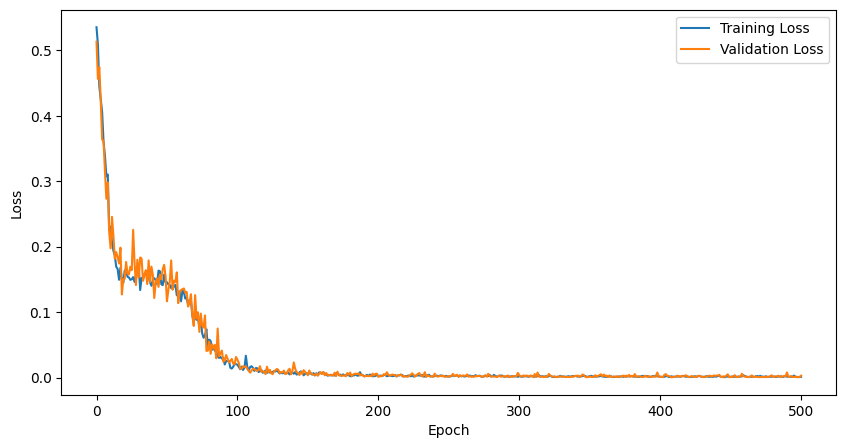

In [46]:
# Model parameters
input_dim = 1
hidden_dim = 64
n_steps = 1000
n_traj = 5000
n_epochs = 501

# Create network and embedding
net = create_network(input_dim, hidden_dim)
time_embed = nn.Sequential(nn.Linear(1, input_dim))

# Prepare data
train_loader, val_loader, test_loader, gmm_samples = prepare_data(
    n_traj=n_traj,
    weights=[0.2, 0.8],
    means=[1, 6],
    sds=[0.5, 1]
)

# Train model
train_losses, val_losses = train_model(net, time_embed, train_loader, val_loader, n_epochs)

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
def produce_samples(net, time_embed,test_data, num_samples=1500, num_timesteps=1000, eps=1e-5):

    num_samples = min(num_samples, len(test_data))

    # Forward process timesteps 
    forward_ts = torch.linspace(0., 1., num_timesteps)
    forward_states = []

    # Generate forward process states
    x0 = test_data[:num_samples].unsqueeze(-1)
    forward_states.append(x0.detach().numpy().copy())  # t=0 state

    with torch.no_grad():
        for t in forward_ts[1:]:  # Start from second time point since we already have t=0
            perturbed = sample_pt(x0, t)
            forward_states.append(perturbed.detach().numpy().copy())

        # Start reverse process with the exact same samples from forward process end
    x = torch.tensor(forward_states[-1], dtype=torch.float32)
    
    # Reverse process timesteps
    reverse_ts = torch.linspace(1., eps, num_timesteps)
    dt = reverse_ts[1] - reverse_ts[0]
    
    # Store reverse process states
    reverse_states = [x.numpy().copy()]

    score_approx = []
    score_truth = []
    
    # Perform reverse SDE
    with torch.no_grad():
        for i in range(len(reverse_ts)-1):
            t = reverse_ts[i]
            t_batch = torch.full((x.shape[0], 1), t)
            t_embed = time_embed(t_batch)
            score = net(torch.cat([x, t_embed], dim=1))

            score_t = compute_score(x, t)

            score_approx.append(score.mean().item())
            score_truth.append(score_t.mean().item())
            
            g_t = diffusion(t)
            drift = -(g_t**2) * score
            noise = g_t * torch.randn_like(x) * torch.sqrt(torch.abs(dt))
            x = x + (drift * dt) + noise
            
            reverse_states.append(x.detach().numpy().copy())

    return forward_states, reverse_states, score_approx, score_truth

# test data split
test_data_new = []
for batch in test_loader:
    test_data_new.append(batch[0].squeeze())
test_data_new = torch.cat(test_data_new)

# After training
f, r, approx_scores, true_scores = produce_samples(net, time_embed, test_data_new, num_samples=1500, num_timesteps= 1000)

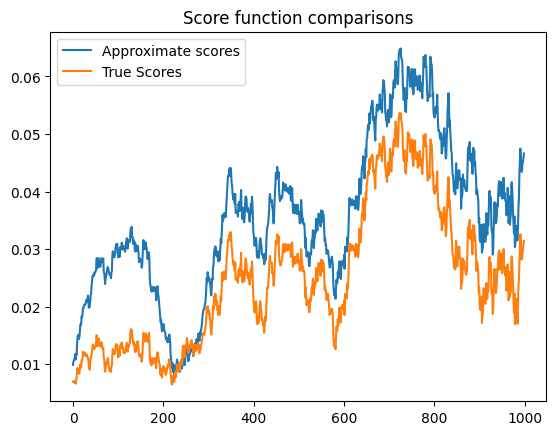

In [48]:
plt.plot(approx_scores)
plt.plot(true_scores)
plt.title('Score function comparisons')
plt.legend(['Approximate scores', 'True Scores'])

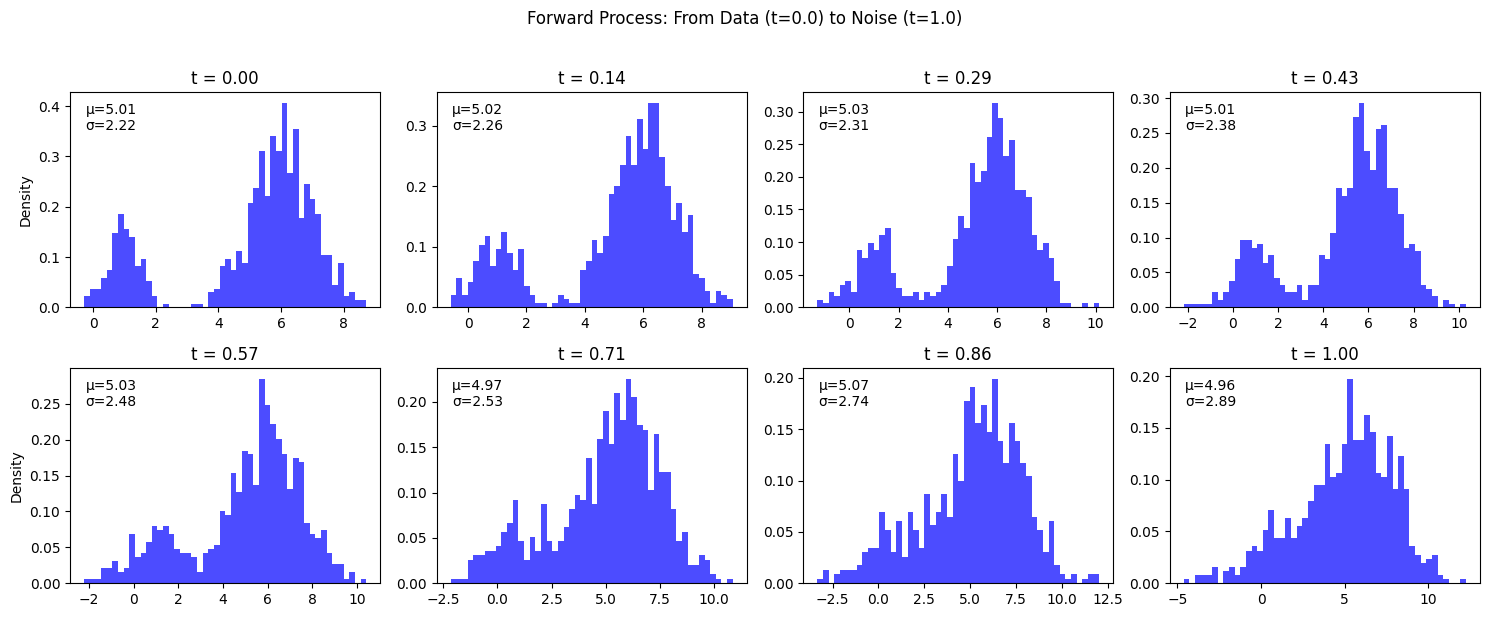

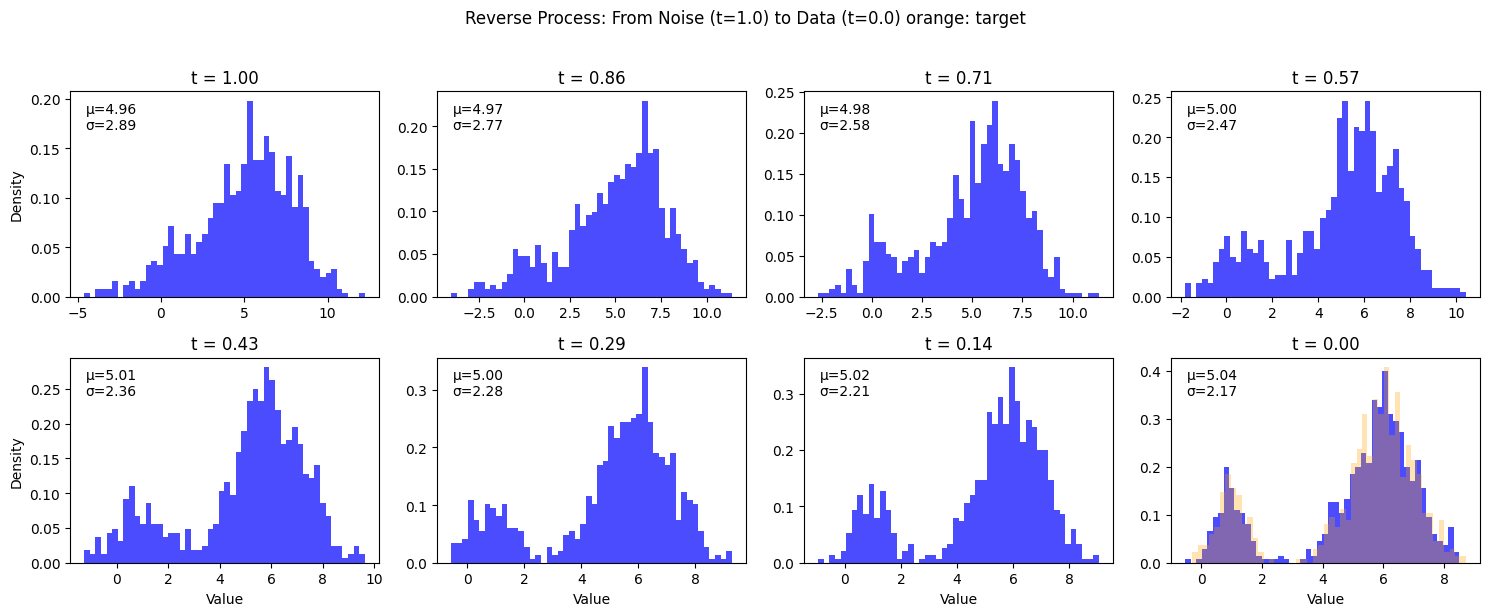

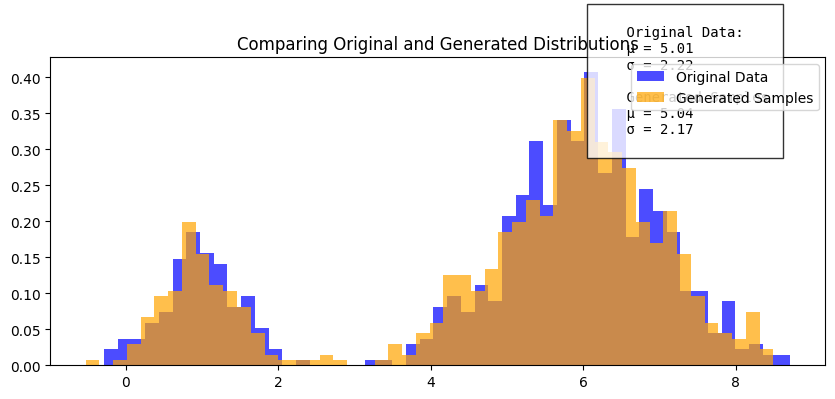

In [49]:
def plot_diffusion_process(forward_states, reverse_states, num_timesteps=8, eps=1e-5):
    """
    Visualizes both forward and reverse diffusion processes with exactly num_timesteps plots
    
    """
    
    total_steps = len(forward_states)
    step_size = total_steps // num_timesteps
    indices = [int(i * (total_steps-1)/(num_timesteps-1)) for i in range(num_timesteps)]

    reverse_indices = [int(i * (total_steps-1)/(num_timesteps-1)) for i in range(num_timesteps)]

    # Calculate subplot layouts
    n_rows = (num_timesteps + 3) // 4
    n_cols = min(4, num_timesteps)
    
    # Forward process timesteps (7 points between 0 and 1, plus t=0)
    forward_ts = torch.linspace(0., 1., num_timesteps)
    
    # Plot forward process
    plt.figure(figsize=(15, 3*n_rows))
    for idx in range(num_timesteps):
        plt.subplot(n_rows, n_cols, idx + 1)
        f_samples = forward_states[indices[idx]]
        plt.hist(f_samples, bins=50, density=True, alpha=0.7, color='blue')
        
        t_val = forward_ts[idx].item()
        plt.title(f't = {t_val:.2f}')
        
        if idx % n_cols == 0:
            plt.ylabel('Density')
        if idx >= len(forward_states) - n_cols:
            plt.xlabel('Value')
        
        mean = np.mean(f_samples)
        std = np.std(f_samples)
        plt.text(0.05, 0.95, f'μ={mean:.2f}\nσ={std:.2f}',
                transform=plt.gca().transAxes,
                verticalalignment='top')
    
    plt.suptitle('Forward Process: From Data (t=0.0) to Noise (t=1.0)', y=1.02)
    plt.tight_layout()
    plt.show()

    # Reverse process timesteps
    reverse_ts = torch.linspace(1., eps, num_timesteps)
    
    # Plot reverse process
    plt.figure(figsize=(15, 3*n_rows))   
    for idx in range(num_timesteps):
        plt.subplot(n_rows, n_cols, idx + 1)
        r_samples = reverse_states[reverse_indices[idx]]
        plt.hist(r_samples, bins=50, density=True, alpha=0.7, color='blue')
        
        if idx == num_timesteps-1:
            plt.hist(forward_states[0], bins=50, density=True, 
                    alpha=0.3, color='orange')
            
        t_val = reverse_ts[idx].item()
        plt.title(f't = {t_val:.2f}')
        
        if idx % n_cols == 0:
            plt.ylabel('Density')
        if idx >= num_timesteps - n_cols:
            plt.xlabel('Value')
        
        mean = np.mean(r_samples)
        std = np.std(r_samples)
        plt.text(0.05, 0.95, f'μ={mean:.2f}\nσ={std:.2f}',
                transform=plt.gca().transAxes,
                verticalalignment='top')
   
    
    plt.suptitle('Reverse Process: From Noise (t=1.0) to Data (t=0.0) orange: target', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Plot comparison of initial and final distributions
    plt.figure(figsize=(10, 4))
    plt.hist(forward_states[0], bins=50, density=True, alpha=0.7,
            label='Original Data', color='blue')
    plt.hist(reverse_states[-1], bins=50, density=True, alpha=0.7,
            label='Generated Samples', color='orange')
    plt.title('Comparing Original and Generated Distributions')
    plt.legend()
    #plt.xlim(-3, 10)
    
    # Add stats comparison
    stats_text = f"""
    Original Data:
    μ = {np.mean(forward_states[0]):.2f}
    σ = {np.std(forward_states[0]):.2f}
    
    Generated Samples:
    μ = {np.mean(reverse_states[-1]):.2f}
    σ = {np.std(reverse_states[-1]):.2f}
    """
    plt.text(0.7, 0.7, stats_text, transform=plt.gca().transAxes,
            fontsize=10, family='monospace', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.show()

plot_diffusion_process(f, r, num_timesteps=8)

(array([ 3.,  5.,  5.,  8., 10., 20., 25., 21., 19., 11., 13.,  7.,  3.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  4.,  5., 11., 13.,
        10., 15., 12., 28., 32., 42., 30., 46., 42., 55., 36., 48., 24.,
        33., 29., 25., 14., 14.,  6., 12.,  3.,  4.,  2.,  2.]),
 array([-0.28817305, -0.10806661,  0.07203982,  0.25214627,  0.43225271,
         0.61235911,  0.79246557,  0.97257203,  1.15267849,  1.33278489,
         1.51289129,  1.69299769,  1.87310421,  2.05321074,  2.23331714,
         2.41342354,  2.59352994,  2.77363634,  2.95374274,  3.13384914,
         3.31395578,  3.49406219,  3.67416859,  3.85427499,  4.03438139,
         4.21448803,  4.39459419,  4.57470083,  4.754807  ,  4.93491364,
         5.11502028,  5.29512644,  5.47523308,  5.65533924,  5.83544588,
         6.01555204,  6.19565868,  6.37576532,  6.55587149,  6.73597813,
         6.91608429,  7.09619093,  7.27629709,  7.45640373,  7.63651037,
         7.81661654,  7.99672318,  8.17682934,  8.3569355 ,

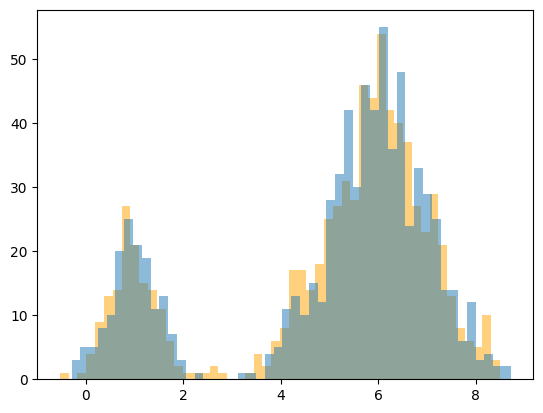

In [50]:
plt.hist(r[-1], bins = 50, color = 'orange', alpha = 0.5)
plt.hist(f[0], bins = 50, alpha = 0.5)

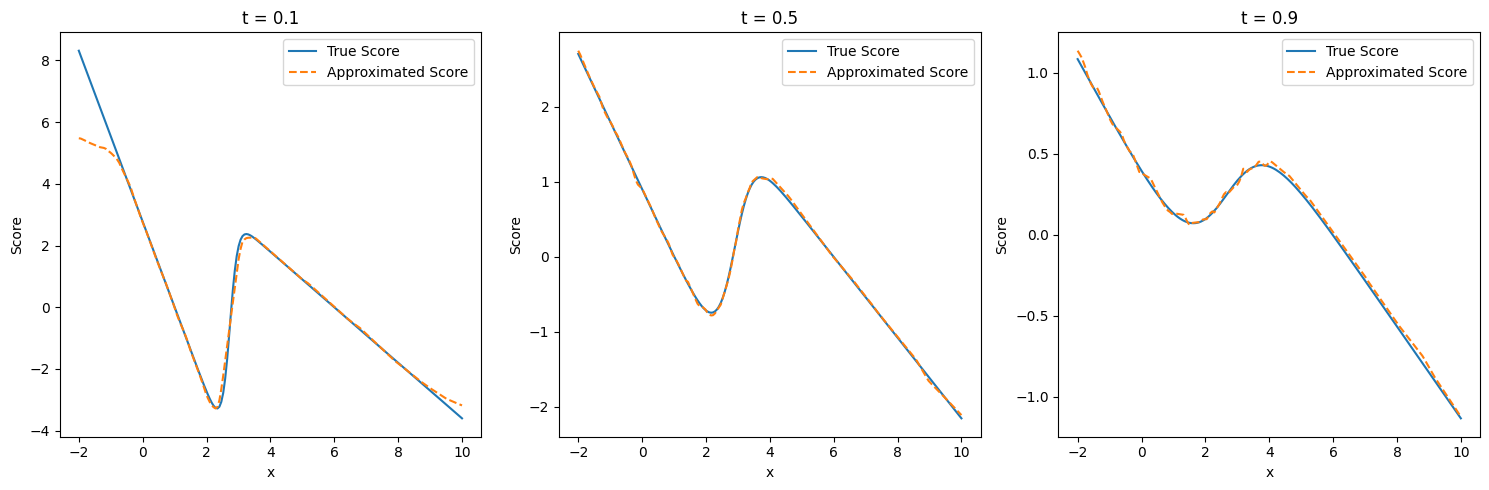

In [51]:
def plot_score_functions(net, time_embed, t_values=[0.1, 0.5, 0.9], x_range=(-2, 10), n_points=200):
    x_values = torch.linspace(x_range[0], x_range[1], n_points).reshape(-1, 1)
    
    plt.figure(figsize=(15, 5))
    for t in t_values:
        # Compute true scores
        true_scores = compute_score(x_values, torch.tensor([t]))
        
        # Compute approximated scores
        t_batch = torch.full((n_points, 1), t)
        t_embed = time_embed(t_batch)
        with torch.no_grad():
            approx_scores = net(torch.cat([x_values, t_embed], dim=1))
        
        # Plot
        plt.subplot(1, len(t_values), t_values.index(t) + 1)
        plt.plot(x_values.numpy(), true_scores.numpy(), label='True Score')
        plt.plot(x_values.numpy(), approx_scores.numpy(), '--', label='Approximated Score')
        plt.title(f't = {t:.1f}')
        plt.xlabel('x')
        plt.ylabel('Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_score_functions(net, time_embed)